In [1]:
%matplotlib inline



Graph Convolutional Network
====================================

**Author:** `Qi Huang <https://github.com/HQ01>`_, `Minjie Wang  <https://jermainewang.github.io/>`_,
Yu Gai, Quan Gan, Zheng Zhang

This is a gentle introduction of using DGL to implement Graph Convolutional
Networks (Kipf & Welling et al., `Semi-Supervised Classification with Graph
Convolutional Networks <https://arxiv.org/pdf/1609.02907.pdf>`_). We build upon
the :doc:`earlier tutorial <../../basics/3_pagerank>` on DGLGraph and demonstrate
how DGL combines graph with deep neural network and learn structural representations.


Model Overview
------------------------------------------
GCN from the perspective of message passing
```````````````````````````````````````````````
We describe a layer of graph convolutional neural network from a message
passing perspective; the math can be found `here <math_>`_.
It boils down to the following step, for each node $u$:

1) Aggregate neighbors' representations $h_{v}$ to produce an
intermediate representation $\hat{h}_u$.  2) Transform the aggregated
representation $\hat{h}_{u}$ with a linear projection followed by a
non-linearity: $h_{u} = f(W_{u} \hat{h}_u)$.

We will implement step 1 with DGL message passing, and step 2 with the
``apply_nodes`` method, whose node UDF will be a PyTorch ``nn.Module``.

GCN implementation with DGL
``````````````````````````````````````````
We first define the message and reduce function as usual.  Since the
aggregation on a node $u$ only involves summing over the neighbors'
representations $h_v$, we can simply use builtin functions:



In [2]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

We then define the node UDF for ``apply_nodes``, which is a fully-connected layer:



In [3]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        if self.activation is not None:
            h = self.activation(h)
        return {'h' : h}

We then proceed to define the GCN module. A GCN layer essentially performs
message passing on all the nodes then applies the `NodeApplyModule`. Note
that we omitted the dropout in the paper for simplicity.



In [4]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the cora dataset (the input feature size is
1433 and the number of classes is 7). The last GCN layer computes node embeddings,
so the last layer in general doesn't apply activation.



In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(1433, 16, F.relu)
        self.gcn2 = GCN(16, 7, None)
    
    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


We load the cora dataset using DGL's built-in data module.



In [6]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    train_mask = th.ByteTensor(data.train_mask)
    test_mask = th.ByteTensor(data.test_mask)
    g = data.graph
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, train_mask, test_mask

When a model is trained, we can use the following method to evaluate
the performance of the model on the test dataset:



In [7]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

We then train the network as follows:



In [8]:
import time
import numpy as np
g, features, labels, train_mask, test_mask = load_cora_data()
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
dur = []
for epoch in range(50):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch >=3:
        dur.append(time.time() - t0)
    
    acc = evaluate(net, g, features, labels, test_mask)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))

Extracting file to /home/sheldonmao/.dgl/cora


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/home/sheldonmao/anaconda3/lib/python3.7

Epoch 00000 | Loss 1.9343 | Test Acc 0.2150 | Time(s) nan
Epoch 00001 | Loss 1.9115 | Test Acc 0.2590 | Time(s) nan


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00002 | Loss 1.8887 | Test Acc 0.3090 | Time(s) nan
Epoch 00003 | Loss 1.8674 | Test Acc 0.3430 | Time(s) 0.0764


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00004 | Loss 1.8452 | Test Acc 0.3740 | Time(s) 0.0776
Epoch 00005 | Loss 1.8223 | Test Acc 0.4200 | Time(s) 0.0736


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00006 | Loss 1.7986 | Test Acc 0.4420 | Time(s) 0.0692
Epoch 00007 | Loss 1.7741 | Test Acc 0.4620 | Time(s) 0.0661
Epoch 00008 | Loss 1.7495 | Test Acc 0.4710 | Time(s) 0.0654

/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068


Epoch 00009 | Loss 1.7244 | Test Acc 0.4860 | Time(s) 0.0648
Epoch 00010 | Loss 1.6990 | Test Acc 0.4850 | Time(s) 0.0620


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00011 | Loss 1.6738 | Test Acc 0.4990 | Time(s) 0.0601
Epoch 00012 | Loss 1.6488 | Test Acc 0.5140 | Time(s) 0.0591
Epoch 00013 | Loss 1.6238 | Test Acc 0.5210 | Time(s) 0.0585


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00014 | Loss 1.5990 | Test Acc 0.5310 | Time(s) 0.0571
Epoch 00015 | Loss 1.5746 | Test Acc 0.5420 | Time(s) 0.0565
Epoch 00016 | Loss 1.5506 | Test Acc 0.5590 | Time(s) 0.0555


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00017 | Loss 1.5270 | Test Acc 0.5740 | Time(s) 0.0553
Epoch 00018 | Loss 1.5040 | Test Acc 0.5790 | Time(s) 0.0545
Epoch 00019 | Loss 1.4815 | Test Acc 0.5810 | Time(s) 0.0541


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00020 | Loss 1.4594 | Test Acc 0.5840 | Time(s) 0.0542
Epoch 00021 | Loss 1.4377 | Test Acc 0.5880 | Time(s) 0.0542
Epoch 00022 | Loss 1.4164 | Test Acc 0.5930 | Time(s) 0.0542


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00023 | Loss 1.3955 | Test Acc 0.5980 | Time(s) 0.0543
Epoch 00024 | Loss 1.3750 | Test Acc 0.6050 | Time(s) 0.0542
Epoch 00025 | Loss 1.3549 | Test Acc 0.6130 | Time(s) 0.0549


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00026 | Loss 1.3352 | Test Acc 0.6190 | Time(s) 0.0547
Epoch 00027 | Loss 1.3158 | Test Acc 0.6280 | Time(s) 0.0541
Epoch 00028 | Loss 1.2966 | Test Acc 0.6280 | Time(s) 0.0542


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00029 | Loss 1.2779 | Test Acc 0.6320 | Time(s) 0.0543
Epoch 00030 | Loss 1.2595 | Test Acc 0.6350 | Time(s) 0.0544


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00031 | Loss 1.2416 | Test Acc 0.6400 | Time(s) 0.0551
Epoch 00032 | Loss 1.2239 | Test Acc 0.6410 | Time(s) 0.0561


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00033 | Loss 1.2066 | Test Acc 0.6430 | Time(s) 0.0564
Epoch 00034 | Loss 1.1897 | Test Acc 0.6520 | Time(s) 0.0564
Epoch 00035 | Loss 1.1731 | Test Acc 0.6600 | Time(s) 0.0564


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00036 | Loss 1.1568 | Test Acc 0.6640 | Time(s) 0.0564
Epoch 00037 | Loss 1.1408 | Test Acc 0.6720 | Time(s) 0.0560
Epoch 00038 | Loss 1.1252 | Test Acc 0.6780 | Time(s) 0.0563


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00039 | Loss 1.1099 | Test Acc 0.6780 | Time(s) 0.0564
Epoch 00040 | Loss 1.0949 | Test Acc 0.6780 | Time(s) 0.0564
Epoch 00041 | Loss 1.0802 | Test Acc 0.6820 | Time(s) 0.0568


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00042 | Loss 1.0658 | Test Acc 0.6840 | Time(s) 0.0571
Epoch 00043 | Loss 1.0518 | Test Acc 0.6840 | Time(s) 0.0572
Epoch 00044 | Loss 1.0380 | Test Acc 0.6850 | Time(s) 0.0570


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00045 | Loss 1.0246 | Test Acc 0.6890 | Time(s) 0.0575
Epoch 00046 | Loss 1.0115 | Test Acc 0.6920 | Time(s) 0.0576


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_15730493068

Epoch 00047 | Loss 0.9987 | Test Acc 0.6940 | Time(s) 0.0579
Epoch 00048 | Loss 0.9862 | Test Acc 0.7020 | Time(s) 0.0585
Epoch 00049 | Loss 0.9739 | Test Acc 0.7050 | Time(s) 0.0588


/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.



GCN in one formula
------------------
Mathematically, the GCN model follows this formula:

$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$

Here, $H^{(l)}$ denotes the $l^{th}$ layer in the network,
$\sigma$ is the non-linearity, and $W$ is the weight matrix for
this layer. $D$ and $A$, as commonly seen, represent degree
matrix and adjacency matrix, respectively. The ~ is a renormalization trick
in which we add a self-connection to each node of the graph, and build the
corresponding degree and adjacency matrix.  The shape of the input
$H^{(0)}$ is $N \times D$, where $N$ is the number of nodes
and $D$ is the number of input features. We can chain up multiple
layers as such to produce a node-level representation output with shape
:$N \times F$, where $F$ is the dimension of the output node
feature vector.

The equation can be efficiently implemented using sparse matrix
multiplication kernels (such as Kipf's
`pygcn <https://github.com/tkipf/pygcn>`_ code). The above DGL implementation
in fact has already used this trick due to the use of builtin functions. To
understand what is under the hood, please read our tutorial on :doc:`PageRank <../../basics/3_pagerank>`.



In [9]:
g

DGLGraph(num_nodes=2708, num_edges=13264,
         ndata_schemes={}
         edata_schemes={})

In [33]:
print(features,features.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([2708, 1433])


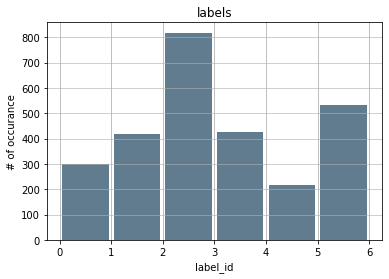

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate data on commute times.
commutes = pd.Series(labels.numpy())

commutes.plot.hist(grid=True, bins=6, rwidth=0.9,
                   color='#607c8e')
plt.title('labels')
plt.xlabel('label_id')
plt.ylabel('# of occurance')
plt.grid(axis='y', alpha=0.75)

In [17]:
print(labels.shape,train_mask.shape,test_mask.shape)

torch.Size([2708]) torch.Size([2708]) torch.Size([2708])
